# Schrodinger equation
---

$$
\begin{aligned}
\varepsilon u_t - i\frac{\epsilon^2}{2}\Delta u + i V(x)u = 0, \ t \in \mathbb{R}, x\in \mathbb{R}^d, \\
u(x, t = 0) = u_0(x),
\end{aligned}
$$
where $V$ is a given electrostatic potential, $0 < \varepsilon \ll 1$.

---

Example 3 in Shi Jin's paper (2008-jy-phase.pdf):
$$
u(x, 0) = \sqrt{n_0(x)}e^{iS_0(x)/\varepsilon},
$$
(3.9-3.10)
$$
n_0(x) = e^{-25x^2}, \ S_0(x) = \frac{1}{\pi}\cos(\pi x)
$$

Periodic BC.

Domain: $[-0.25, 0.25]\times [0, 0.5]$.

---

Consider the real and imag part of $u$, i.e., 
$$
u(x, t) = p(x, t) + iq(x, t),
$$
then
$$
\begin{aligned}
&\varepsilon p_t+\frac{\varepsilon^2}{2}q_{xx} - V(x)q = 0, \\
&\varepsilon q_t-\frac{\varepsilon^2}{2}p_{xx} + V(x)p = 0,
\end{aligned}
$$
with ic
$$
p(x, 0) = e^{-25x^2}\cos(\frac{1}{\pi}\cos(\pi x)/\varepsilon), \ q(x, 0) = e^{-25x^2}\sin(\frac{1}{\pi}\cos(\pi x)/\varepsilon),
$$
and bc
$$
p(x_0, t) = p(x_1, t), q(x_0, t) = q(x_1, t), p_x(x_0, t) = p_x(x_1, t), q_x(x_0, t) = q_x(x_1, t).
$$

In [1]:
NAME = "1"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers
from jax.ops import index, index_add, index_update

import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *
from Seismic_wave_inversion_PINN.jax_model import *

from collections import namedtuple

In [3]:
key = random.PRNGKey(1001)
key, subkey = random.split(key, 2)

layers = [3] + [64]*4 + [2] # (cos(2pi*x), sin(2pi*x), t) -> (u, v)
c0 = 6.0
# w0 = jnp.array([[1.0], [1.0]]) # (w_x, w_t)
w0 = 10.0
w1 = 1.0
lambda_0 = 1e-6
direct_params = init_siren_params(subkey, layers, c0, w0, w1)
# direct_params = init_tanh_params(subkey, layers)

domain = jnp.array([[-0.25, 0.], [0.25, 0.5]])
spatial_width = domain[1, 0]-domain[0, 0]
epsilon = 1.0
V = 0.0

# @jax.jit
# def 

@jax.jit
def model(params, xt):
	# first, normalize to [-1, 1] <- enforce periodic bc
# 	xt = jnp.sin(2.0*jnp.pi*(xt - domain[0, :])/(domain[1, :]-domain[0, :]) - jnp.pi)
# 	xt = jnp.sin(2*jnp.pi*xt/(domain[1, :]-domain[0, :]))

	xt = jnp.dot(xt, jnp.array([[1.0, 1.0, 0.0], [0.0, 0.0, 1.0]]))
	xt = index_update(xt, index[0], jnp.sin(2*jnp.pi*xt[0]/spatial_width))
	xt = index_update(xt, index[1], jnp.cos(2*jnp.pi*xt[1]/spatial_width))
	for w, b in params[:-1]:
		xt = jnp.sin(jnp.dot(xt, w) + b)
	return jnp.dot(xt, params[-1][0]) + params[-1][1]

jacobian = jacrev_fn(model)
hessian = hessian_fn(model)

In [4]:
metaloss = mae

jit_conservation = lambda i: jax.partial(jax.jit, static_argnums = i)

@jax.jit
def loss_fn_(params, batch):
	collocation, dirichlet = batch["collocation"], batch["dirichlet"]
	direct_params = params
	
	uv_c = model(direct_params, jnp.hstack([collocation.x, collocation.t]))
	u_c, v_c = uv_c[:, 0:1], uv_c[:, 1:2]
	
	# jacobian[i] = [[du/dx, du/dt],
	#                [dv/dx, dv/dt]]
	# i: the i^th input
	duv_dxt_c = jacobian(direct_params, jnp.hstack([collocation.x, collocation.t]))
	du_dt_c, dv_dt_c = duv_dxt_c[:, 0:1, 1], duv_dxt_c[:, 1:2, 1]
	
	# hessian[i] = [
    #				[[du/dxx, du/dxy],
	#                [du/dxy, du/dyy]],
	#               [[dv/dxx, dv/dxy],
	#                [dv/dxy, dv/dyy]]
	#              ]
	duv_dxxtt_c = hessian(direct_params, jnp.hstack([collocation.x, collocation.t]))
	du_dxx_c, dv_dxx_c = duv_dxxtt_c[:, 0:1, 0, 0], duv_dxxtt_c[:, 1:2, 0, 0] 
		
	uv_d = model(direct_params, jnp.hstack([dirichlet.x, dirichlet.t]))
	u_d, v_d = uv_d[:, 0:1], uv_d[:, 1:2]
	
	loss_c1 = metaloss(epsilon*du_dt_c + 0.5*epsilon**2*dv_dxx_c - V*v_c, 0)
	loss_c2 = metaloss(epsilon*dv_dt_c - 0.5*epsilon**2*du_dxx_c + V*u_c, 0)
	loss_c = loss_c1 + loss_c2
	
	loss_d1 = metaloss(u_d, dirichlet.u)
	loss_d2 = metaloss(v_d, dirichlet.v)
	loss_d = loss_d1 + loss_d2
	
	return loss_c, loss_d


@jax.jit
def loss_fn(params, batch):
	w = batch["weights"]
	loss_c, loss_d = loss_fn_(params, batch)
	return w["c"]*loss_c + w["d"]*loss_d + l2_regularization(params, lambda_0)

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	w = batch["weights"]
	loss_c, loss_d = loss_fn_(params, batch)
	return w["c"]*loss_c + w["d"]*loss_d, loss_c, loss_d

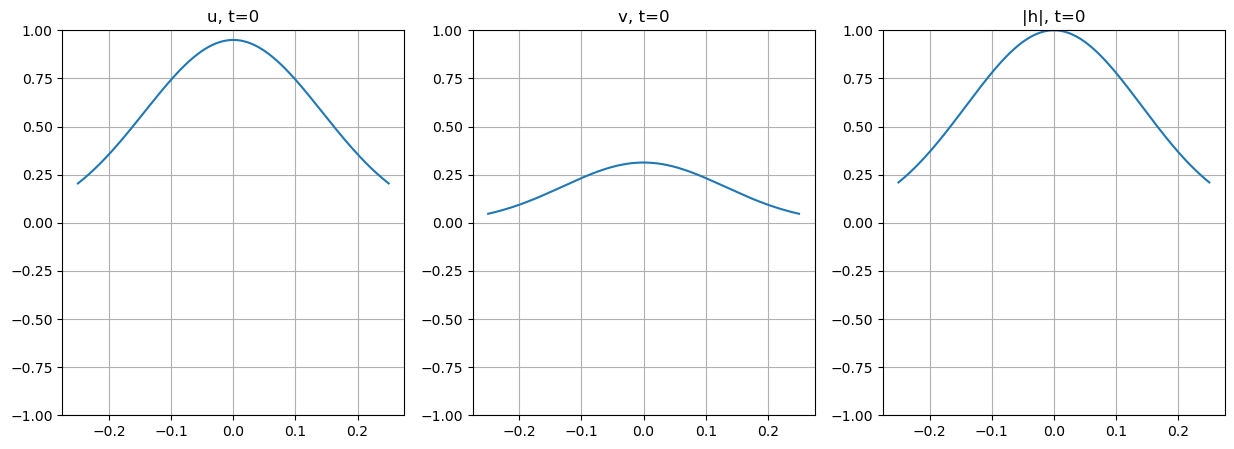

In [5]:
u0_fn = lambda x, t: np.exp(-25*x**2)*np.cos(1/(np.pi*epsilon)*np.cos(np.pi*x))
v0_fn = lambda x, t: np.exp(-25*x**2)*np.sin(1/(np.pi*epsilon)*np.cos(np.pi*x))
x0 = np.linspace(*domain[:, 0], 1000)
t0 = np.zeros_like(x0)
u0 = u0_fn(x0, t0)
v0 = v0_fn(x0, t0)

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

f, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].plot(x0, u0)
ax[0].set_title("u, t=0")
ax[0].grid()
ax[0].set_ylim([-1, 1])
ax[1].plot(x0, v0)
ax[1].set_title("v, t=0")
ax[1].grid()
ax[1].set_ylim([-1, 1])
ax[2].plot(x0, np.sqrt(u0**2+v0**2))
ax[2].set_title("|h|, t=0")
ax[2].grid()
ax[2].set_ylim([-1, 1])
plt.show()

key, *subkeys = random.split(key, 3)

n_i = 1000
x_i = random.uniform(subkeys[0], (n_i, 1), jnp.float32, *domain[:, 0])
t_i = jnp.zeros_like(x_i)
u_i = u0_fn(x_i, t_i)
v_i = v0_fn(x_i, t_i)

n_cx = 1000
x_c = jnp.linspace(*domain[:, 0], n_cx).reshape((-1, 1))

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "t", "u", "v"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "t"])

dirichlet = dataset_Dirichlet(x_i, t_i, u_i, v_i)
collocation = dataset_Collocation(jnp.vstack([dirichlet.x]),
								 jnp.vstack([dirichlet.t]))

class Time_Marching_Generator:
	def __init__(self, key, spatial_points, temporal_domain, batch_size, iterations, update_every):
		self.key = key
		self.spatial_points = spatial_points
		self.domain = temporal_domain
		self.batch_size = batch_size
		self.iterations = iterations
		self._count1 = -1
		self._count2 = update_every
		self.update_every = update_every
		
	def _update(self, key, tmax):
		self._t = random.uniform(key, (self.batch_size, 1), jnp.float32, self.domain[0], tmax)
		
	def __iter__(self):
		return self
	
	def __next__(self):
		if self._count2 == self.update_every:
			self._count1 = max(self.iterations, self._count1 + 1)
			tmax = self.domain[0] + (self.domain[1]-self.domain[0])*self._count1/self.iterations
			self.key, subkey = random.split(self.key)
			self._update(subkey, tmax)
			self._count2 = 0
		else:
			self._count2 += 1
		return self.spatial_points, self._t

In [6]:
# pre-train

lr = 1e-3
start_iteration = 0
iterations = 200000
print_every = 1000
save_every = 10000
batch_size = {"dirichlet": 1000, "collocation": 1000}
weights = {"c": 1e-2, "d": 1.0}

key, *subkeys = random.split(key, 5)
Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Collocation = Time_Marching_Generator(subkeys[3], x_c, [0, 0], n_cx, iterations, 1)

params = direct_params
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
hist = {"iter": [], "loss": []}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]])),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/11, 15:05:25, Iteration: 0, Train Loss: 2.5925e+02, c: 2.5774e+04, d: 1.5065e+00
2020/08/11, 15:05:32, Iteration: 1000, Train Loss: 2.4630e+00, c: 2.3141e+02, d: 1.4892e-01
2020/08/11, 15:05:39, Iteration: 2000, Train Loss: 1.9730e+00, c: 1.9198e+02, d: 5.3186e-02
2020/08/11, 15:05:46, Iteration: 3000, Train Loss: 1.6691e+00, c: 1.6379e+02, d: 3.1211e-02
2020/08/11, 15:05:53, Iteration: 4000, Train Loss: 1.3024e+00, c: 1.2830e+02, d: 1.9394e-02
2020/08/11, 15:06:01, Iteration: 5000, Train Loss: 9.6248e-01, c: 9.4850e+01, d: 1.3985e-02
2020/08/11, 15:06:08, Iteration: 6000, Train Loss: 6.7085e-01, c: 6.5901e+01, d: 1.1837e-02
2020/08/11, 15:06:15, Iteration: 7000, Train Loss: 6.7454e-01, c: 6.6543e+01, d: 9.1102e-03
2020/08/11, 15:06:22, Iteration: 8000, Train Loss: 5.2949e-01, c: 5.1944e+01, d: 1.0055e-02
2020/08/11, 15:06:29, Iteration: 9000, Train Loss: 3.6522e-01, c: 3.5910e+01, d: 6.1164e-03
2020/08/11, 15:06:36, Iteration: 10000, Train Loss: 3.2214e-01, c: 3.1455e+01, d: 7

2020/08/11, 15:16:35, Iteration: 89000, Train Loss: 1.5213e-03, c: 1.4024e-02, d: 1.3810e-03
2020/08/11, 15:16:43, Iteration: 90000, Train Loss: 1.7713e-03, c: 9.1243e-03, d: 1.6801e-03
2020/08/11, 15:16:50, Iteration: 91000, Train Loss: 2.3502e-03, c: 8.8836e-03, d: 2.2614e-03
2020/08/11, 15:16:58, Iteration: 92000, Train Loss: 1.6036e-03, c: 1.8126e-02, d: 1.4223e-03
2020/08/11, 15:17:06, Iteration: 93000, Train Loss: 2.1144e-03, c: 1.2814e-02, d: 1.9863e-03
2020/08/11, 15:17:13, Iteration: 94000, Train Loss: 8.9321e-04, c: 2.2784e-02, d: 6.6537e-04
2020/08/11, 15:17:21, Iteration: 95000, Train Loss: 1.5913e-03, c: 4.9118e-02, d: 1.1001e-03
2020/08/11, 15:17:28, Iteration: 96000, Train Loss: 1.4764e-03, c: 4.8493e-03, d: 1.4279e-03
2020/08/11, 15:17:36, Iteration: 97000, Train Loss: 1.8984e-03, c: 1.9332e-02, d: 1.7051e-03
2020/08/11, 15:17:44, Iteration: 98000, Train Loss: 1.3985e-03, c: 1.0134e-02, d: 1.2971e-03
2020/08/11, 15:17:51, Iteration: 99000, Train Loss: 1.4863e-03, c: 8.1

2020/08/11, 15:27:42, Iteration: 177000, Train Loss: 1.7569e-03, c: 1.0077e-02, d: 1.6561e-03
2020/08/11, 15:27:50, Iteration: 178000, Train Loss: 1.8561e-03, c: 4.8777e-03, d: 1.8073e-03
2020/08/11, 15:27:57, Iteration: 179000, Train Loss: 7.8289e-04, c: 1.0388e-02, d: 6.7901e-04
2020/08/11, 15:28:05, Iteration: 180000, Train Loss: 1.6195e-03, c: 1.1920e-02, d: 1.5003e-03
2020/08/11, 15:28:12, Iteration: 181000, Train Loss: 1.1835e-03, c: 8.0116e-03, d: 1.1034e-03
2020/08/11, 15:28:20, Iteration: 182000, Train Loss: 4.2395e-04, c: 4.4773e-03, d: 3.7918e-04
2020/08/11, 15:28:28, Iteration: 183000, Train Loss: 9.9674e-04, c: 5.1612e-03, d: 9.4513e-04
2020/08/11, 15:28:35, Iteration: 184000, Train Loss: 1.2359e-03, c: 4.6837e-03, d: 1.1891e-03
2020/08/11, 15:28:43, Iteration: 185000, Train Loss: 1.7636e-03, c: 6.7928e-03, d: 1.6957e-03
2020/08/11, 15:28:50, Iteration: 186000, Train Loss: 7.3229e-04, c: 4.6212e-03, d: 6.8608e-04
2020/08/11, 15:28:58, Iteration: 187000, Train Loss: 1.6440e

In [8]:
# pre-train

lr = 1e-3
start_iteration = 0
iterations = 1000000
print_every = 1000
save_every = 10000
batch_size = {"dirichlet": 1000, "collocation": 1000}
weights = {"c": 1e-2, "d": 1.0}

key, *subkeys = random.split(key, 5)
Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Collocation = Time_Marching_Generator(subkeys[3], x_c, domain[:, 1], n_cx, iterations, 1)

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]])),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/11, 15:36:30, Iteration: 0, Train Loss: 9.4388e-02, c: 9.3620e+00, d: 7.6808e-04
2020/08/11, 15:36:40, Iteration: 1000, Train Loss: 1.1798e-03, c: 2.2525e-02, d: 9.5455e-04
2020/08/11, 15:36:49, Iteration: 2000, Train Loss: 1.0047e-03, c: 7.2412e-03, d: 9.3228e-04
2020/08/11, 15:36:59, Iteration: 3000, Train Loss: 8.0141e-04, c: 7.0416e-03, d: 7.3100e-04
2020/08/11, 15:37:09, Iteration: 4000, Train Loss: 1.6073e-03, c: 5.5587e-03, d: 1.5517e-03
2020/08/11, 15:37:19, Iteration: 5000, Train Loss: 8.1365e-04, c: 4.1350e-03, d: 7.7230e-04
2020/08/11, 15:37:28, Iteration: 6000, Train Loss: 1.4817e-03, c: 3.7606e-03, d: 1.4441e-03
2020/08/11, 15:37:38, Iteration: 7000, Train Loss: 1.0966e-03, c: 7.4097e-03, d: 1.0225e-03
2020/08/11, 15:37:48, Iteration: 8000, Train Loss: 8.9825e-04, c: 5.1950e-03, d: 8.4630e-04
2020/08/11, 15:37:57, Iteration: 9000, Train Loss: 2.1379e-03, c: 6.4249e-03, d: 2.0737e-03
2020/08/11, 15:38:07, Iteration: 10000, Train Loss: 1.4566e-03, c: 1.7281e-02, d: 1

2020/08/11, 15:50:56, Iteration: 89000, Train Loss: 1.0419e-03, c: 3.6759e-03, d: 1.0051e-03
2020/08/11, 15:51:06, Iteration: 90000, Train Loss: 9.2437e-04, c: 1.6810e-03, d: 9.0756e-04
2020/08/11, 15:51:16, Iteration: 91000, Train Loss: 8.1871e-04, c: 2.5759e-03, d: 7.9295e-04
2020/08/11, 15:51:25, Iteration: 92000, Train Loss: 1.6509e-03, c: 2.3833e-03, d: 1.6271e-03
2020/08/11, 15:51:35, Iteration: 93000, Train Loss: 5.0370e-04, c: 6.9741e-03, d: 4.3396e-04
2020/08/11, 15:51:45, Iteration: 94000, Train Loss: 1.0334e-03, c: 1.2572e-02, d: 9.0772e-04
2020/08/11, 15:51:55, Iteration: 95000, Train Loss: 1.5853e-03, c: 2.5305e-03, d: 1.5600e-03
2020/08/11, 15:52:04, Iteration: 96000, Train Loss: 1.2466e-03, c: 3.8229e-03, d: 1.2084e-03
2020/08/11, 15:52:14, Iteration: 97000, Train Loss: 9.0054e-04, c: 2.1163e-03, d: 8.7937e-04
2020/08/11, 15:52:24, Iteration: 98000, Train Loss: 9.2780e-04, c: 1.7776e-03, d: 9.1002e-04
2020/08/11, 15:52:33, Iteration: 99000, Train Loss: 1.3982e-03, c: 2.7

2020/08/11, 16:05:13, Iteration: 177000, Train Loss: 1.4700e-03, c: 2.1794e-03, d: 1.4482e-03
2020/08/11, 16:05:23, Iteration: 178000, Train Loss: 1.3963e-03, c: 8.7352e-03, d: 1.3089e-03
2020/08/11, 16:05:33, Iteration: 179000, Train Loss: 1.8863e-03, c: 3.6903e-03, d: 1.8494e-03
2020/08/11, 16:05:42, Iteration: 180000, Train Loss: 1.1797e-03, c: 6.5231e-03, d: 1.1144e-03
2020/08/11, 16:05:52, Iteration: 181000, Train Loss: 1.6658e-03, c: 2.0437e-03, d: 1.6454e-03
2020/08/11, 16:06:02, Iteration: 182000, Train Loss: 7.9319e-04, c: 1.8202e-03, d: 7.7499e-04
2020/08/11, 16:06:12, Iteration: 183000, Train Loss: 1.3614e-03, c: 1.3661e-03, d: 1.3477e-03
2020/08/11, 16:06:21, Iteration: 184000, Train Loss: 6.2919e-04, c: 2.0840e-03, d: 6.0835e-04
2020/08/11, 16:06:31, Iteration: 185000, Train Loss: 1.4394e-03, c: 2.3305e-03, d: 1.4161e-03
2020/08/11, 16:06:41, Iteration: 186000, Train Loss: 7.6690e-04, c: 2.8752e-03, d: 7.3815e-04
2020/08/11, 16:06:50, Iteration: 187000, Train Loss: 4.4128e

2020/08/11, 16:19:32, Iteration: 265000, Train Loss: 1.2580e-03, c: 1.8546e-03, d: 1.2395e-03
2020/08/11, 16:19:42, Iteration: 266000, Train Loss: 8.9286e-04, c: 1.6612e-03, d: 8.7625e-04
2020/08/11, 16:19:52, Iteration: 267000, Train Loss: 6.7012e-04, c: 2.6345e-03, d: 6.4378e-04
2020/08/11, 16:20:02, Iteration: 268000, Train Loss: 1.4106e-03, c: 1.2137e-03, d: 1.3985e-03
2020/08/11, 16:20:11, Iteration: 269000, Train Loss: 9.7951e-04, c: 1.8684e-03, d: 9.6082e-04
2020/08/11, 16:20:21, Iteration: 270000, Train Loss: 8.7801e-04, c: 2.0425e-03, d: 8.5759e-04
2020/08/11, 16:20:31, Iteration: 271000, Train Loss: 1.0670e-03, c: 2.2915e-03, d: 1.0441e-03
2020/08/11, 16:20:41, Iteration: 272000, Train Loss: 1.3924e-03, c: 3.5653e-03, d: 1.3567e-03
2020/08/11, 16:20:50, Iteration: 273000, Train Loss: 1.4177e-03, c: 2.1951e-03, d: 1.3958e-03
2020/08/11, 16:21:00, Iteration: 274000, Train Loss: 1.6119e-03, c: 3.3542e-03, d: 1.5784e-03
2020/08/11, 16:21:10, Iteration: 275000, Train Loss: 8.8173e

2020/08/11, 16:33:48, Iteration: 353000, Train Loss: 9.2559e-04, c: 3.6575e-03, d: 8.8902e-04
2020/08/11, 16:33:58, Iteration: 354000, Train Loss: 7.0357e-04, c: 1.6413e-03, d: 6.8715e-04
2020/08/11, 16:34:08, Iteration: 355000, Train Loss: 1.8529e-03, c: 3.7483e-03, d: 1.8154e-03
2020/08/11, 16:34:18, Iteration: 356000, Train Loss: 9.4113e-04, c: 2.2187e-03, d: 9.1894e-04
2020/08/11, 16:34:27, Iteration: 357000, Train Loss: 1.7692e-03, c: 2.3623e-03, d: 1.7456e-03
2020/08/11, 16:34:37, Iteration: 358000, Train Loss: 6.5837e-04, c: 2.5630e-03, d: 6.3273e-04
2020/08/11, 16:34:47, Iteration: 359000, Train Loss: 7.1079e-04, c: 7.9087e-03, d: 6.3170e-04
2020/08/11, 16:34:57, Iteration: 360000, Train Loss: 1.3795e-03, c: 1.9120e-03, d: 1.3603e-03
2020/08/11, 16:35:06, Iteration: 361000, Train Loss: 4.1781e-04, c: 2.0158e-03, d: 3.9765e-04
2020/08/11, 16:35:16, Iteration: 362000, Train Loss: 8.1603e-04, c: 1.1085e-03, d: 8.0494e-04
2020/08/11, 16:35:26, Iteration: 363000, Train Loss: 8.7093e

2020/08/11, 16:48:05, Iteration: 441000, Train Loss: 9.2089e-04, c: 1.9214e-03, d: 9.0167e-04
2020/08/11, 16:48:15, Iteration: 442000, Train Loss: 1.2860e-03, c: 8.7638e-03, d: 1.1983e-03
2020/08/11, 16:48:25, Iteration: 443000, Train Loss: 1.5065e-03, c: 3.2269e-03, d: 1.4742e-03
2020/08/11, 16:48:35, Iteration: 444000, Train Loss: 1.1737e-03, c: 3.7940e-03, d: 1.1357e-03
2020/08/11, 16:48:44, Iteration: 445000, Train Loss: 9.3033e-04, c: 5.0717e-03, d: 8.7961e-04
2020/08/11, 16:48:54, Iteration: 446000, Train Loss: 9.0314e-04, c: 1.0919e-02, d: 7.9395e-04
2020/08/11, 16:49:04, Iteration: 447000, Train Loss: 1.0660e-03, c: 2.9959e-03, d: 1.0360e-03
2020/08/11, 16:49:13, Iteration: 448000, Train Loss: 6.8810e-04, c: 4.3476e-03, d: 6.4462e-04
2020/08/11, 16:49:23, Iteration: 449000, Train Loss: 9.3144e-04, c: 8.6566e-03, d: 8.4487e-04
2020/08/11, 16:49:33, Iteration: 450000, Train Loss: 9.2347e-04, c: 2.1826e-03, d: 9.0164e-04
2020/08/11, 16:49:43, Iteration: 451000, Train Loss: 7.0416e

2020/08/11, 17:02:20, Iteration: 529000, Train Loss: 1.4784e-03, c: 1.2167e-02, d: 1.3567e-03
2020/08/11, 17:02:30, Iteration: 530000, Train Loss: 7.1884e-04, c: 3.4333e-03, d: 6.8450e-04
2020/08/11, 17:02:39, Iteration: 531000, Train Loss: 8.3230e-04, c: 3.1453e-03, d: 8.0084e-04
2020/08/11, 17:02:49, Iteration: 532000, Train Loss: 7.5566e-04, c: 5.1236e-03, d: 7.0442e-04
2020/08/11, 17:02:59, Iteration: 533000, Train Loss: 8.4336e-04, c: 1.7370e-03, d: 8.2599e-04
2020/08/11, 17:03:09, Iteration: 534000, Train Loss: 1.5608e-03, c: 4.5241e-03, d: 1.5156e-03
2020/08/11, 17:03:18, Iteration: 535000, Train Loss: 1.0094e-03, c: 1.7650e-03, d: 9.9173e-04
2020/08/11, 17:03:28, Iteration: 536000, Train Loss: 5.9522e-04, c: 1.3895e-03, d: 5.8133e-04
2020/08/11, 17:03:38, Iteration: 537000, Train Loss: 7.4350e-04, c: 6.1606e-03, d: 6.8190e-04
2020/08/11, 17:03:48, Iteration: 538000, Train Loss: 8.1090e-04, c: 3.4156e-03, d: 7.7675e-04
2020/08/11, 17:03:57, Iteration: 539000, Train Loss: 1.2595e

2020/08/11, 17:16:40, Iteration: 617000, Train Loss: 6.8383e-04, c: 1.6297e-03, d: 6.6753e-04
2020/08/11, 17:16:50, Iteration: 618000, Train Loss: 4.3835e-04, c: 2.2192e-03, d: 4.1615e-04
2020/08/11, 17:17:00, Iteration: 619000, Train Loss: 7.5287e-04, c: 2.9617e-03, d: 7.2325e-04
2020/08/11, 17:17:09, Iteration: 620000, Train Loss: 1.0558e-03, c: 2.8793e-03, d: 1.0270e-03
2020/08/11, 17:17:19, Iteration: 621000, Train Loss: 1.0941e-03, c: 1.6848e-03, d: 1.0772e-03
2020/08/11, 17:17:29, Iteration: 622000, Train Loss: 1.0974e-03, c: 3.6956e-03, d: 1.0604e-03
2020/08/11, 17:17:39, Iteration: 623000, Train Loss: 5.2742e-04, c: 1.0552e-03, d: 5.1686e-04
2020/08/11, 17:17:49, Iteration: 624000, Train Loss: 1.4748e-03, c: 1.4805e-03, d: 1.4600e-03
2020/08/11, 17:17:59, Iteration: 625000, Train Loss: 8.2411e-04, c: 3.7235e-03, d: 7.8688e-04
2020/08/11, 17:18:09, Iteration: 626000, Train Loss: 5.3213e-04, c: 1.0739e-03, d: 5.2139e-04
2020/08/11, 17:18:18, Iteration: 627000, Train Loss: 1.4819e

2020/08/11, 17:30:59, Iteration: 705000, Train Loss: 1.0296e-03, c: 1.9869e-03, d: 1.0097e-03
2020/08/11, 17:31:09, Iteration: 706000, Train Loss: 1.3555e-03, c: 1.6544e-03, d: 1.3390e-03
2020/08/11, 17:31:19, Iteration: 707000, Train Loss: 1.2893e-03, c: 2.4347e-03, d: 1.2650e-03
2020/08/11, 17:31:29, Iteration: 708000, Train Loss: 5.8496e-04, c: 1.0867e-03, d: 5.7409e-04
2020/08/11, 17:31:38, Iteration: 709000, Train Loss: 7.0864e-04, c: 1.2405e-03, d: 6.9623e-04
2020/08/11, 17:31:48, Iteration: 710000, Train Loss: 1.0890e-03, c: 2.2661e-03, d: 1.0664e-03
2020/08/11, 17:31:57, Iteration: 711000, Train Loss: 7.4728e-04, c: 5.1227e-03, d: 6.9605e-04
2020/08/11, 17:32:07, Iteration: 712000, Train Loss: 1.0261e-03, c: 3.2038e-03, d: 9.9407e-04
2020/08/11, 17:32:17, Iteration: 713000, Train Loss: 1.1467e-03, c: 1.2222e-03, d: 1.1345e-03
2020/08/11, 17:32:27, Iteration: 714000, Train Loss: 7.7089e-04, c: 1.6046e-02, d: 6.1043e-04
2020/08/11, 17:32:37, Iteration: 715000, Train Loss: 5.1674e

2020/08/11, 17:45:18, Iteration: 793000, Train Loss: 6.6826e-04, c: 2.2401e-03, d: 6.4586e-04
2020/08/11, 17:45:28, Iteration: 794000, Train Loss: 6.6798e-04, c: 1.9046e-03, d: 6.4894e-04
2020/08/11, 17:45:38, Iteration: 795000, Train Loss: 1.2731e-03, c: 1.4778e-03, d: 1.2583e-03
2020/08/11, 17:45:47, Iteration: 796000, Train Loss: 5.5847e-04, c: 3.2332e-03, d: 5.2614e-04
2020/08/11, 17:45:57, Iteration: 797000, Train Loss: 8.1468e-04, c: 4.2526e-03, d: 7.7216e-04
2020/08/11, 17:46:07, Iteration: 798000, Train Loss: 1.0787e-03, c: 4.1133e-03, d: 1.0375e-03
2020/08/11, 17:46:16, Iteration: 799000, Train Loss: 4.6726e-04, c: 2.0849e-03, d: 4.4641e-04
2020/08/11, 17:46:26, Iteration: 800000, Train Loss: 8.4893e-04, c: 1.6745e-03, d: 8.3218e-04
2020/08/11, 17:46:35, Iteration: 801000, Train Loss: 9.3713e-04, c: 1.4299e-03, d: 9.2283e-04
2020/08/11, 17:46:45, Iteration: 802000, Train Loss: 7.1774e-04, c: 2.9825e-03, d: 6.8791e-04
2020/08/11, 17:46:55, Iteration: 803000, Train Loss: 8.2452e

2020/08/11, 17:59:36, Iteration: 881000, Train Loss: 9.2325e-04, c: 1.4045e-03, d: 9.0920e-04
2020/08/11, 17:59:46, Iteration: 882000, Train Loss: 8.8693e-04, c: 6.2340e-03, d: 8.2459e-04
2020/08/11, 17:59:56, Iteration: 883000, Train Loss: 7.1113e-04, c: 1.7291e-03, d: 6.9384e-04
2020/08/11, 18:00:06, Iteration: 884000, Train Loss: 5.1287e-04, c: 1.1327e-03, d: 5.0154e-04
2020/08/11, 18:00:15, Iteration: 885000, Train Loss: 7.7268e-04, c: 2.9064e-03, d: 7.4361e-04
2020/08/11, 18:00:25, Iteration: 886000, Train Loss: 6.2064e-04, c: 1.7129e-03, d: 6.0352e-04
2020/08/11, 18:00:35, Iteration: 887000, Train Loss: 1.2524e-03, c: 1.4243e-03, d: 1.2381e-03
2020/08/11, 18:00:45, Iteration: 888000, Train Loss: 7.0673e-04, c: 3.0768e-03, d: 6.7596e-04
2020/08/11, 18:00:54, Iteration: 889000, Train Loss: 5.9087e-04, c: 1.5881e-03, d: 5.7499e-04
2020/08/11, 18:01:04, Iteration: 890000, Train Loss: 1.3191e-03, c: 2.9769e-03, d: 1.2893e-03
2020/08/11, 18:01:14, Iteration: 891000, Train Loss: 6.8675e

2020/08/11, 18:13:54, Iteration: 969000, Train Loss: 5.0635e-04, c: 2.0840e-03, d: 4.8551e-04
2020/08/11, 18:14:04, Iteration: 970000, Train Loss: 5.9245e-04, c: 8.4566e-03, d: 5.0789e-04
2020/08/11, 18:14:13, Iteration: 971000, Train Loss: 5.6868e-04, c: 2.3011e-03, d: 5.4566e-04
2020/08/11, 18:14:23, Iteration: 972000, Train Loss: 4.6945e-04, c: 2.2506e-03, d: 4.4695e-04
2020/08/11, 18:14:33, Iteration: 973000, Train Loss: 5.7984e-04, c: 1.6326e-03, d: 5.6351e-04
2020/08/11, 18:14:43, Iteration: 974000, Train Loss: 6.1078e-04, c: 2.9192e-03, d: 5.8159e-04
2020/08/11, 18:14:52, Iteration: 975000, Train Loss: 4.8675e-04, c: 1.0077e-03, d: 4.7668e-04
2020/08/11, 18:15:02, Iteration: 976000, Train Loss: 5.6950e-04, c: 2.8308e-03, d: 5.4119e-04
2020/08/11, 18:15:12, Iteration: 977000, Train Loss: 8.5218e-04, c: 2.5611e-03, d: 8.2657e-04
2020/08/11, 18:15:22, Iteration: 978000, Train Loss: 1.1674e-03, c: 2.2160e-03, d: 1.1452e-03
2020/08/11, 18:15:31, Iteration: 979000, Train Loss: 6.1488e

In [10]:
from scipy.io import loadmat

uv_true = loadmat("ex3_epsilon_1.0.mat")["u"].T

from matplotlib import animation
%matplotlib notebook

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
lines = []
for i in range(3):
    line1, = ax[i].plot([], [], lw = 1.5, label = "true")
    line2, = ax[i].plot([], [], lw = 1.5, label = "pred")
    lines.extend([line1, line2])
    ax[i].set_xlim([-0.25, 0.25])
    ax[i].set_ylim([-1, 1])
    ax[i].legend()
    ax[i].grid()
    
def init():
	for line in lines:
		line.set_data([], [])
	return lines

params_ = get_params(opt_state)

x_test = jnp.linspace(*domain[:, 0], 1024)
t_test = jnp.linspace(*domain[:, 1], 501)
xt_tests = [tensor_grid([x_test, ti]) for ti in t_test]
uv_preds = [model(params_, xt_test) for xt_test in xt_tests]
u_preds, v_preds = [uv_pred[:, 0:1] for uv_pred in uv_preds], [uv_pred[:, 1:2] for uv_pred in uv_preds]

def animate(i):
	u_pred, v_pred = u_preds[i], v_preds[i]
	u_true, v_true = np.real(uv_true[i, :]), np.imag(uv_true[i, :])
	
	lines[0].set_data(x_test, u_true)
	lines[1].set_data(x_test, u_pred)
	ax[0].set_title("u, t = {:.2f}".format(t_test[i]))
    
	lines[2].set_data(x_test, v_true)
	lines[3].set_data(x_test, v_pred)
	ax[1].set_title("v, t = {:.2f}".format(t_test[i]))

	lines[4].set_data(x_test, np.sqrt(u_true**2+v_true**2))
	lines[5].set_data(x_test, np.sqrt(u_pred**2+v_pred**2))
	ax[2].set_title("|h|, t = {:.2f}".format(t_test[i]))

	return lines

anim = animation.FuncAnimation(fig, animate, frames = len(t_test), interval = 10, blit = True)
plt.show()

<IPython.core.display.Javascript object>

In [11]:
duv_dxt_c = jacobian(get_params(opt_state), jnp.hstack([collocation.x, collocation.t]))
du_dt_c, dv_dt_c = duv_dxt_c[:, 0:1, 1], duv_dxt_c[:, 1:2, 1]
du_dt_c

DeviceArray([[-1.35447544e-06],
             [-6.40387088e-06],
             [ 7.81873405e-06],
             [-7.09059987e-06],
             [-2.14334909e-06],
             [-2.52055111e-06],
             [-2.55155283e-06],
             [-5.90199107e-08],
             [ 1.48104409e-05],
             [-5.19927562e-06],
             [ 1.32779378e-05],
             [ 1.48525442e-05],
             [ 4.23308904e-07],
             [ 2.65824383e-06],
             [-4.14969463e-06],
             [-4.56509360e-06],
             [-1.32448974e-06],
             [ 2.32876232e-06],
             [ 1.13174683e-05],
             [ 9.29023736e-06],
             [ 1.92586072e-06],
             [ 4.47514458e-06],
             [-2.12598275e-06],
             [-6.59231910e-06],
             [-5.67361712e-06],
             [ 2.19490903e-06],
             [ 1.31545621e-05],
             [-5.14901603e-06],
             [-6.75430329e-06],
             [-5.28882993e-06],
             [-5.63166031e-06],
        